# Human Face Recognition using PCA

## Data Exploration

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

figures_dir = "../figures"
os.makedirs(figures_dir, exist_ok=True)

### Load the dataset

In [2]:
print("Loading LFW dataset...")
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = lfw_dataset.images
X = lfw_dataset.data
n_samples, h, w = images.shape
target_names = lfw_dataset.target_names
n_classes = len(target_names)

print(f"Dataset loaded with {n_samples} samples.")
print(f"Image dimensions: {h}x{w}")
print(f"Number of classes: {n_classes}")
print("Classes:", target_names)

Loading LFW dataset...
Dataset loaded with 1288 samples.
Image dimensions: 50x37
Number of classes: 7
Classes: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


**Dataset Overview**

- **Dataset Name:** Labeled Faces in the Wild (LFW)
- **Number of Samples:** 1,288 images
- **Image Dimensions:** 50x37 pixels (height x width)
- **Number of Classes:** 7 distinct individuals
- **Class Labels:**
  - Ariel Sharon
  - Colin Powell
  - Donald Rumsfeld
  - George W. Bush
  - Gerhard Schroeder
  - Hugo Chavez
  - Tony Blair

This dataset contains facial images with a minimum of 70 images per individual. The smaller image dimensions (50x37) and the limited number of classes make it suitable for tasks such as facial recognition, classification, and feature extraction experiments.

### Visualizing a few images from the dataset

Displaying sample images...


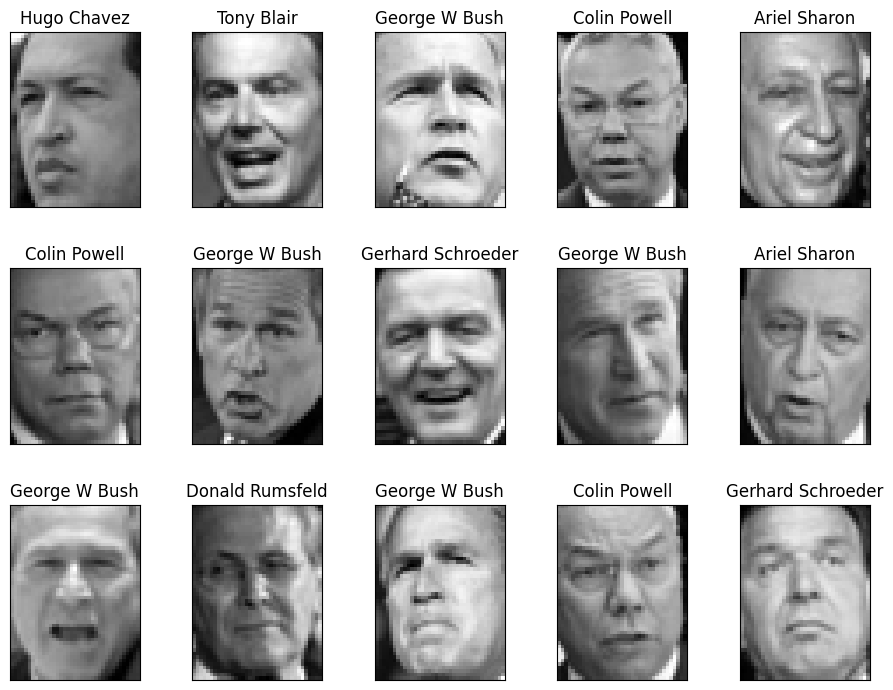

In [3]:
# Step 2: Visualize a few sample images
def plot_sample_images(images, target, target_names, h, w, n_row=3, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(target_names[target[i]], size=12)
        plt.xticks(())
        plt.yticks(())
    save_path = os.path.join(figures_dir, "sample_images.png")
    plt.savefig(save_path)
    plt.show()

print("Displaying sample images...")
plot_sample_images(images, lfw_dataset.target, target_names, h, w)

### Analyzing the dataset

Analyzing pixel intensity distribution...


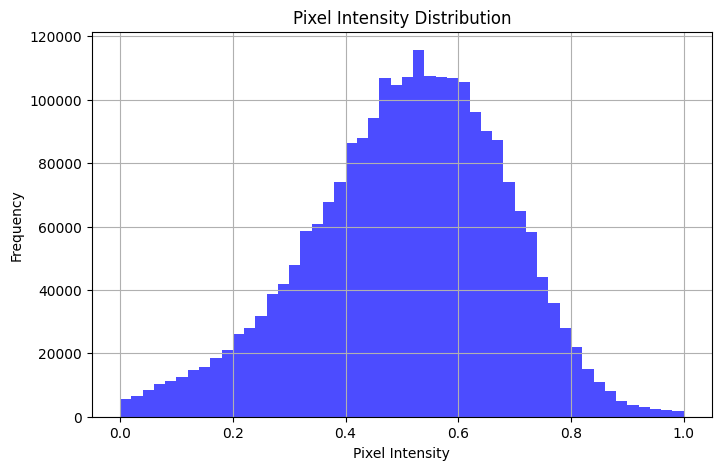

In [4]:
# Step 3: Analyze pixel intensity distribution
def plot_pixel_distribution(images):
    pixel_values = images.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    save_path = os.path.join(figures_dir, "pixel_intensity.png")
    plt.savefig(save_path)
    plt.show()

print("Analyzing pixel intensity distribution...")
plot_pixel_distribution(images)

Analyzing class distribution...


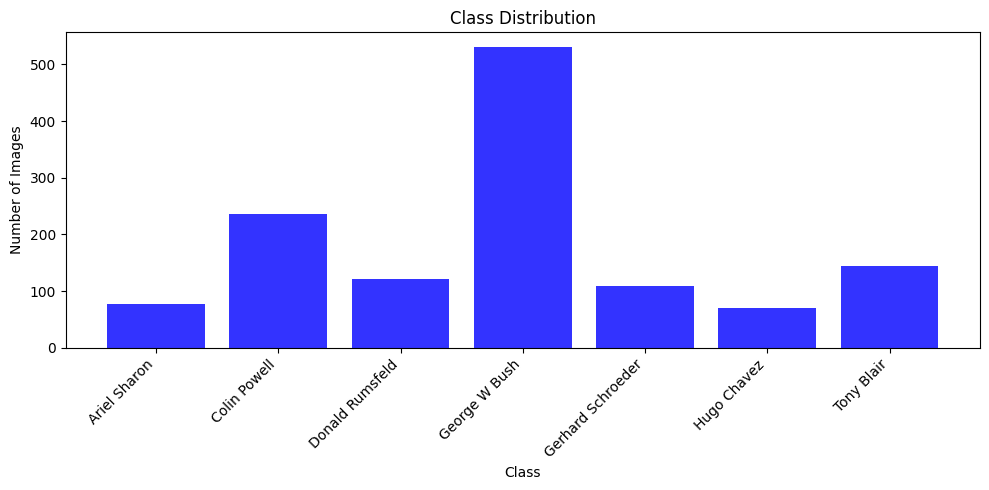

In [5]:
# Step 4: Class distribution
def plot_class_distribution(target, target_names):
    class_counts = np.bincount(target)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(target_names)), class_counts, color='blue', alpha=0.8)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(range(len(target_names)), target_names, rotation=45, ha="right")
    plt.tight_layout()
    save_path = os.path.join(figures_dir, "class_distribution.png")
    plt.savefig(save_path)
    plt.show()

print("Analyzing class distribution...")
plot_class_distribution(lfw_dataset.target, target_names)

In [6]:
# Step 5: Summary statistics for images
def compute_image_statistics(images):
    mean_image = np.mean(images, axis=0)
    std_image = np.std(images, axis=0)
    return mean_image, std_image

mean_image, std_image = compute_image_statistics(X)

Visualizing mean and standard deviation of images...


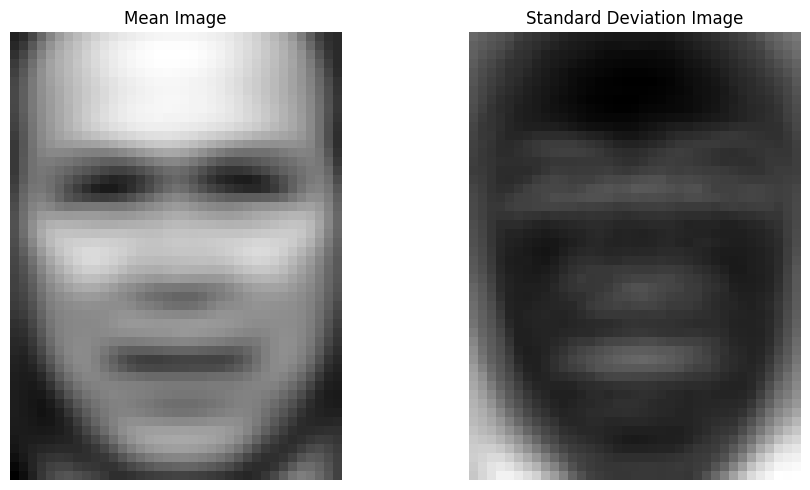

In [7]:
# Visualize mean and standard deviation images
def plot_image_statistics(mean_image, std_image, h, w):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title("Mean Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(std_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title("Standard Deviation Image")
    plt.axis("off")
    plt.tight_layout()
    save_path = os.path.join(figures_dir, "mean_sd.png")
    plt.savefig(save_path)
    plt.show()

print("Visualizing mean and standard deviation of images...")
plot_image_statistics(mean_image, std_image, h, w)

## PCA and Sparse PCA

### Standardizing the data

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA Implementation

In [30]:
print("Performing PCA...")
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
pca_components = pca.components_

print(f"Shape of X_scaled: {X_scaled.shape}")  # Standardized features
print(f"Shape of X_pca: {X_pca.shape}")  # Reduced features

Performing PCA...
Shape of X_scaled: (1288, 1850)
Shape of X_pca: (1288, 171)


### Sparse PCA Implementation

In [31]:
# Define Sparse PCA with desired number of components
n_components = 171 
sparse_pca = SparsePCA(n_components=n_components, random_state=42, alpha=1)

# Fit and transform the data
X_sparse_pca = sparse_pca.fit_transform(X_scaled)
sparse_pca_components = sparse_pca.components_

# Print shapes
print(f"Shape of X_scaled: {X_scaled.shape}")  # Standardized features
print(f"Shape of X_sparse_pca: {X_sparse_pca.shape}")  # Reduced features

Shape of X_scaled: (1288, 1850)
Shape of X_sparse_pca: (1288, 171)


### MiniBatchSparsePCA Implementation

In [32]:
# Define Mini Batch Sparse PCA with desired number of components
mbsparse_pca = MiniBatchSparsePCA(n_components=n_components, alpha=0.1, batch_size=100, max_iter=50, random_state=42)

# Fit and transform the data
X_mbsparse_pca = mbsparse_pca.fit_transform(X_scaled)
mbsparse_pca_components = mbsparse_pca.components_

# Print shapes
print(f"Shape of X_scaled: {X_scaled.shape}")  # Standardized features
print(f"Shape of X_sparse_pca: {X_mbsparse_pca.shape}")  # Reduced features

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 94 iterations, alpha=3.450e-04, previous alpha=3.450e-04, with an active set of 69 regressors.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 161 iterations, alpha=8.173e-05, previous alpha=8.173e-05, with an active set of 142 regressors.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 119 iterations, alpha=1.738e-04, previous alpha=1.738e-04, with an active set of 116 regressors.
  warnin

Shape of X_scaled: (1288, 1850)
Shape of X_sparse_pca: (1288, 171)


### Visualizing the top principal components

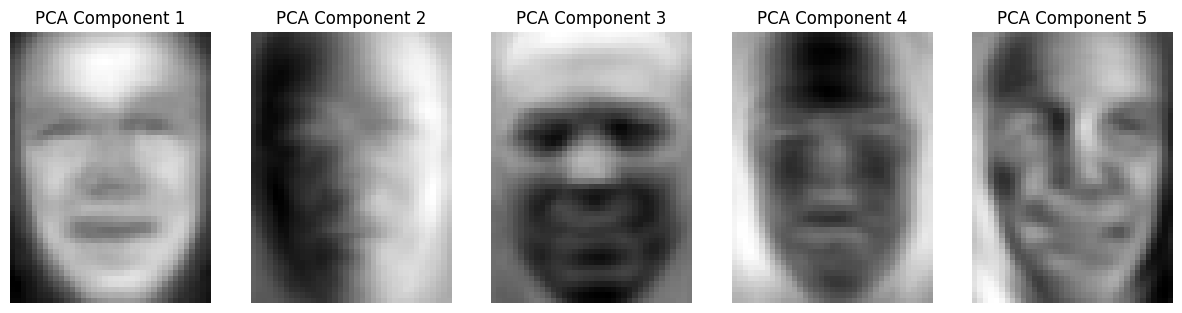

In [33]:
# Visualize the first few PCA components as images
n_visualize = 5  # Number of components to visualize
plt.figure(figsize=(15, 5))

for i in range(n_visualize):
    plt.subplot(1, n_visualize, i + 1)
    plt.imshow(pca_components[i].reshape(h, w), cmap='gray')
    plt.title(f"PCA Component {i+1}")
    plt.axis('off')

plt.show()

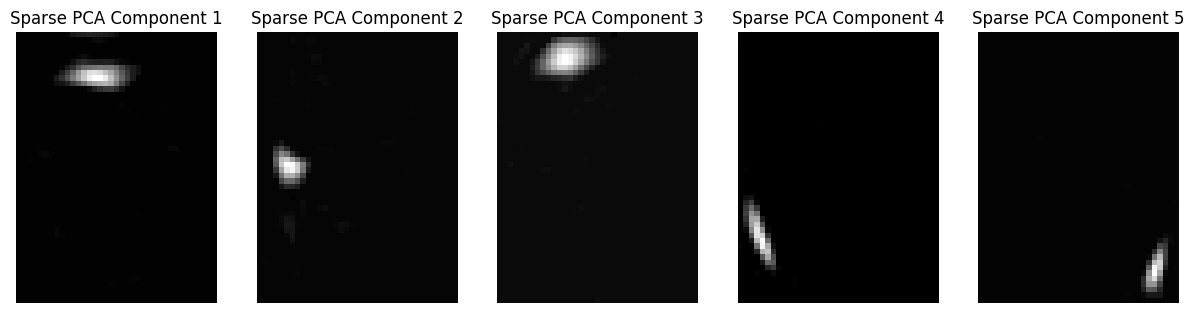

In [34]:
n_visualize = 5  # Number of components to visualize
plt.figure(figsize=(15, 5))

for i in range(n_visualize):
    plt.subplot(1, n_visualize, i + 1)
    plt.imshow(sparse_pca_components[i].reshape(h, w), cmap='gray')
    plt.title(f"Sparse PCA Component {i+1}")
    plt.axis('off')

plt.show()

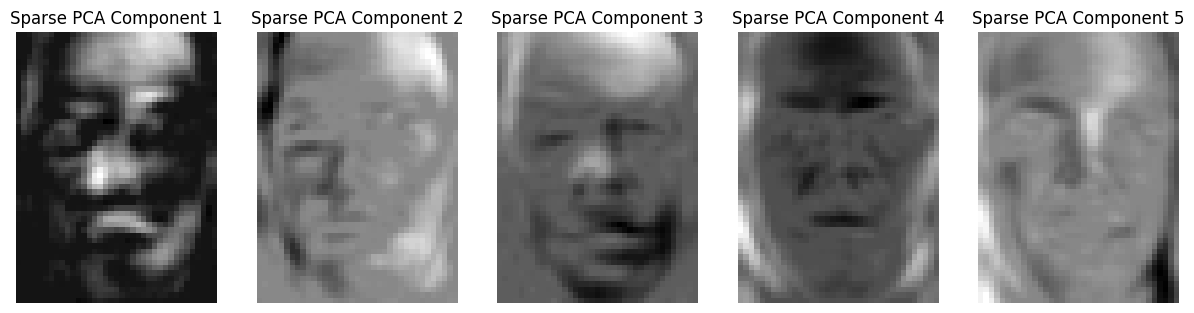

In [35]:
n_visualize = 5  # Number of components to visualize
plt.figure(figsize=(15, 5))

for i in range(n_visualize):
    plt.subplot(1, n_visualize, i + 1)
    plt.imshow(mbsparse_pca_components[i].reshape(h, w), cmap='gray')
    plt.title(f"Sparse PCA Component {i+1}")
    plt.axis('off')

plt.show()

### 2D Visualization of the dataset

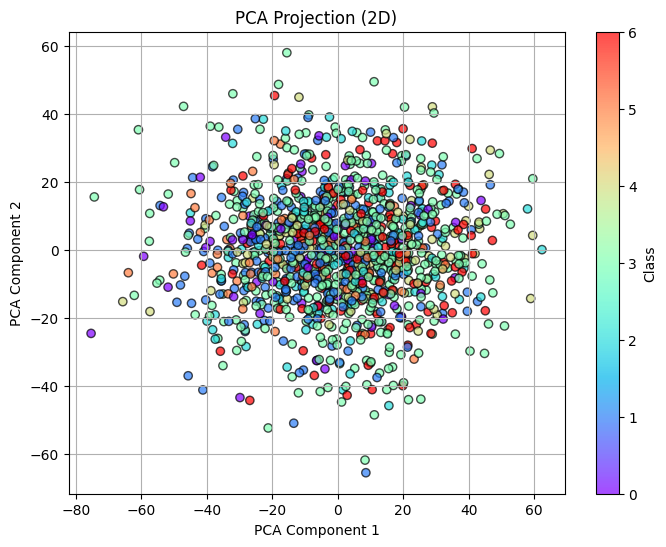

In [36]:
# 2D PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=lfw_dataset.target, cmap='rainbow', alpha=0.7, edgecolor='k')
plt.colorbar(ticks=range(len(target_names)), label="Class")
plt.title("PCA Projection (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

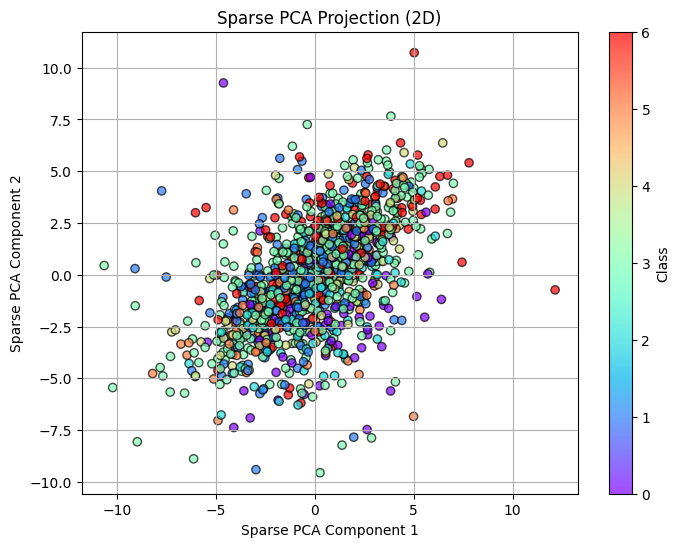

In [37]:
# 2D Sparse PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_sparse_pca[:, 0], X_sparse_pca[:, 1], c=lfw_dataset.target, cmap='rainbow', alpha=0.7, edgecolor='k')
plt.colorbar(ticks=range(len(target_names)), label="Class")
plt.title("Sparse PCA Projection (2D)")
plt.xlabel("Sparse PCA Component 1")
plt.ylabel("Sparse PCA Component 2")
plt.grid()
plt.show()

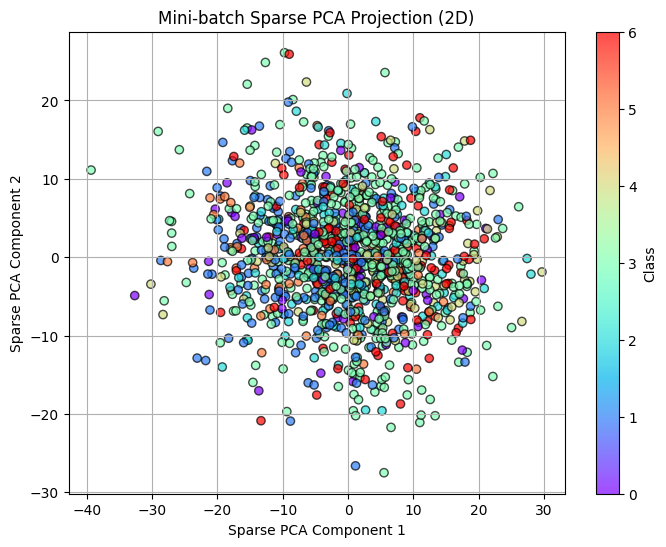

In [38]:
# 2D Mini-batch Sparse PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_mbsparse_pca[:, 0], X_mbsparse_pca[:, 1], c=lfw_dataset.target, cmap='rainbow', alpha=0.7, edgecolor='k')
plt.colorbar(ticks=range(len(target_names)), label="Class")
plt.title("Mini-batch Sparse PCA Projection (2D)")
plt.xlabel("Sparse PCA Component 1")
plt.ylabel("Sparse PCA Component 2")
plt.grid()
plt.show()

### 3D Visualization of the dataset

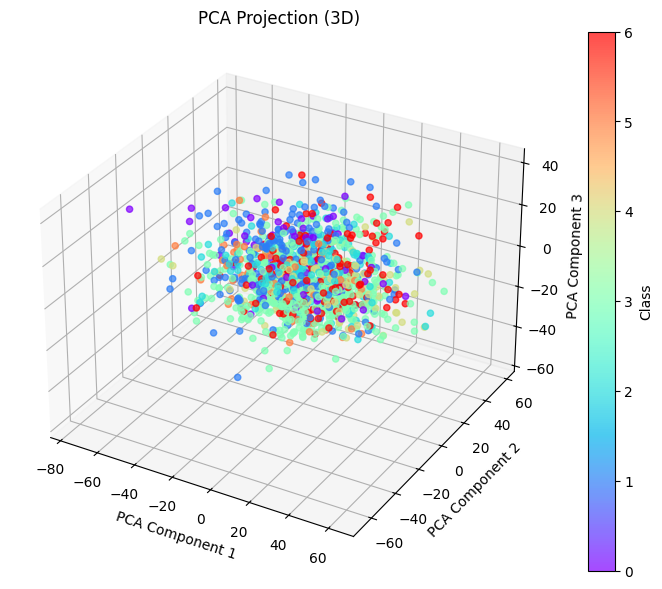

In [39]:
# 3D PCA visualization (if n_components >= 3)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=lfw_dataset.target, cmap='rainbow', alpha=0.7)
plt.colorbar(scatter, label="Class")
ax.set_title("PCA Projection (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()

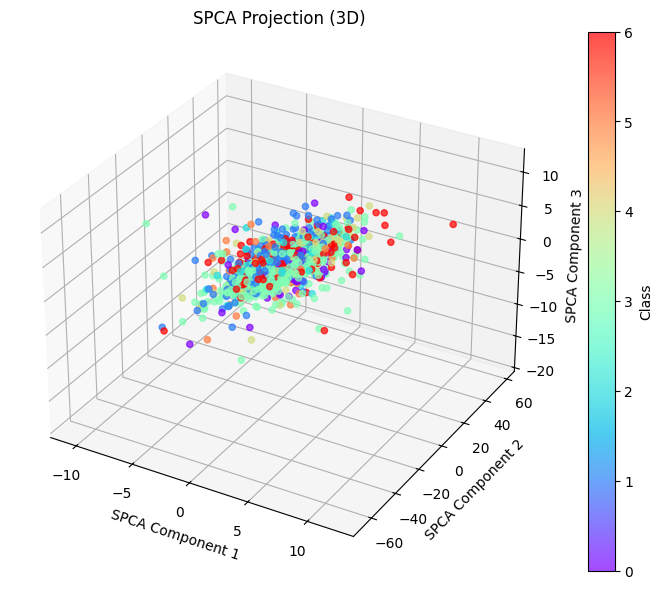

In [40]:
# 3D Sparse PCA visualization (if n_components >= 3)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sparse_pca[:, 0], X_pca[:, 1], X_sparse_pca[:, 2], c=lfw_dataset.target, cmap='rainbow', alpha=0.7)
plt.colorbar(scatter, label="Class")
ax.set_title("SPCA Projection (3D)")
ax.set_xlabel("SPCA Component 1")
ax.set_ylabel("SPCA Component 2")
ax.set_zlabel("SPCA Component 3")
plt.show()

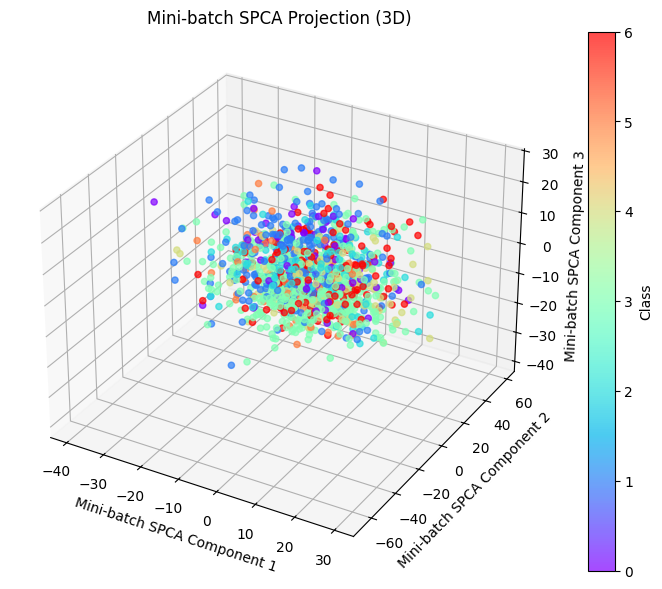

In [41]:
# 3D MB Sparse PCA visualization (if n_components >= 3)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_mbsparse_pca[:, 0], X_pca[:, 1], X_mbsparse_pca[:, 2], c=lfw_dataset.target, cmap='rainbow', alpha=0.7)
plt.colorbar(scatter, label="Class")
ax.set_title("Mini-batch SPCA Projection (3D)")
ax.set_xlabel("Mini-batch SPCA Component 1")
ax.set_ylabel("Mini-batch SPCA Component 2")
ax.set_zlabel("Mini-batch SPCA Component 3")
plt.show()

## Support Vector Machine

Train test split

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, lfw_dataset.target, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

X_train_pca, X_test_pca,  y_train, y_test= train_test_split(
    X_pca, lfw_dataset.target, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

X_train_sparse_pca, X_test_sparse_pca, y_train, y_test = train_test_split(
    X_sparse_pca, lfw_dataset.target, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

X_train_mbsparse_pca, X_test_mbsparse_pca, y_train, y_test = train_test_split(
    X_mbsparse_pca, lfw_dataset.target, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [1, 5, 10, 20],  # Test various regularization strengths
    'gamma': ['scale', 0.1, 0.01, 0.001]  # Test different gamma values
}

# Instantiate the SVC model
svm = SVC(kernel='rbf', random_state=42)

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Results for raw data:")

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.4f}')

# Use the best parameters to make predictions on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data with tuned parameters: {acc:.4f}')

# print classifiction results 
print(classification_report(y_test, y_pred, target_names = target_names)) 
# print confusion matrix 
print("Confusion Matrix is:") 
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Results for raw data:
Best Parameters: {'C': 5, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.8068
Accuracy on test data with tuned parameters: 0.8450
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        11
     Colin Powell       0.80      0.91      0.85        47
  Donald Rumsfeld       0.93      0.64      0.76        22
    George W Bush       0.84      0.96      0.90       119
Gerhard Schroeder       0.75      0.79      0.77        19
      Hugo Chavez       1.00      0.38      0.56        13
       Tony Blair       0.95      0.70      0.81        27

         accuracy                           0.84       258
        macro avg       0.88      0.73      0.78       258
     weighted avg       0.86      0.84      0.84       258

Confusion Matrix is:
[[  8   1   1   1   0   0   0]
 [  1  43   0   3   0   0   0]
 [  0   1  14   7   0   0   0]
 [  0   4   0 114   1   0   0]
 [  0   0   0   3  15   0   1]
 [  0   3   0  

In [44]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Results for PCA:")

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.4f}')

# Use the best parameters to make predictions on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data with tuned parameters: {acc:.4f}')

# print classifiction results 
print(classification_report(y_test, y_pred, target_names = target_names)) 
# print confusion matrix 
print("Confusion Matrix is:") 
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Results for PCA:
Best Parameters: {'C': 5, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.8087
Accuracy on test data with tuned parameters: 0.8488
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        11
     Colin Powell       0.81      0.94      0.87        47
  Donald Rumsfeld       0.93      0.64      0.76        22
    George W Bush       0.84      0.96      0.89       119
Gerhard Schroeder       0.78      0.74      0.76        19
      Hugo Chavez       1.00      0.38      0.56        13
       Tony Blair       0.95      0.74      0.83        27

         accuracy                           0.85       258
        macro avg       0.89      0.73      0.78       258
     weighted avg       0.86      0.85      0.84       258

Confusion Matrix is:
[[  8   0   1   2   0   0   0]
 [  1  44   0   2   0   0   0]
 [  0   1  14   7   0   0   0]
 [  0   4   0 114   1   0   0]
 [  0   1   0   3  14   0   1]
 [  0   3   0   4   

In [45]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_sparse_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Results for SPCA:")

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.4f}')

# Use the best parameters to make predictions on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_sparse_pca)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data with tuned parameters: {acc:.4f}')

# print classifiction results 
print(classification_report(y_test, y_pred, target_names = target_names)) 
# print confusion matrix 
print("Confusion Matrix is:") 
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Results for SPCA:
Best Parameters: {'C': 5, 'gamma': 0.001}
Best Cross-Validation Accuracy: 0.8165
Accuracy on test data with tuned parameters: 0.8372
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.64      0.74        11
     Colin Powell       0.80      0.91      0.85        47
  Donald Rumsfeld       0.87      0.59      0.70        22
    George W Bush       0.83      0.97      0.89       119
Gerhard Schroeder       0.83      0.79      0.81        19
      Hugo Chavez       1.00      0.23      0.38        13
       Tony Blair       0.91      0.74      0.82        27

         accuracy                           0.84       258
        macro avg       0.87      0.70      0.74       258
     weighted avg       0.85      0.84      0.82       258

Confusion Matrix is:
[[  7   1   2   1   0   0   0]
 [  1  43   0   2   0   0   1]
 [  0   2  13   7   0   0   0]
 [  0   3   0 115   1   0   0]
 [  0   0   0   3  15   0   1]
 [  0   3   0   6   1

In [47]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_mbsparse_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Results for Mini Batch SPCA:")

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.4f}')

# Use the best parameters to make predictions on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_mbsparse_pca)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data with tuned parameters: {acc:.4f}')

# print classifiction results 
print(classification_report(y_test, y_pred, target_names = target_names)) 
# print confusion matrix 
print("Confusion Matrix is:") 
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Results for Mini Batch SPCA:
Best Parameters: {'C': 5, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.8175
Accuracy on test data with tuned parameters: 0.8605
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        11
     Colin Powell       0.85      0.96      0.90        47
  Donald Rumsfeld       0.93      0.64      0.76        22
    George W Bush       0.85      0.97      0.90       119
Gerhard Schroeder       0.79      0.79      0.79        19
      Hugo Chavez       1.00      0.31      0.47        13
       Tony Blair       0.95      0.78      0.86        27

         accuracy                           0.86       258
        macro avg       0.89      0.74      0.78       258
     weighted avg       0.87      0.86      0.85       258

Confusion Matrix is:
[[  8   0   1   2   0   0   0]
 [  1  45   0   1   0   0   0]
 [  0   1  14   7   0   0   0]
 [  0   3   0 115   1   0   0]
 [  0   0   0   3  15   0   1]
 [  0   

## K-Nearest Neighbors Classifier

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid for k-NN
param_grid_knn = {
    'n_neighbors': [1, 2, 3, 4, 5, 7, 10, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

print("Results for raw data:")

# Instantiate the k-NN model
knn = KNeighborsClassifier()

# Setup the GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search_knn.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print(f'Best Parameters: {best_params_knn}')
print(f'Best Cross-Validation Accuracy: {best_score_knn:.4f}')

# Use the best parameters to make predictions on the test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on test data with tuned parameters: {acc_knn:.4f}')

# Print classification results
print(classification_report(y_test, y_pred_knn, target_names=target_names))
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred_knn, labels=range(n_classes)))

Results for raw data:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6107
Accuracy on test data with tuned parameters: 0.6550
                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.36      0.36        11
     Colin Powell       0.71      0.68      0.70        47
  Donald Rumsfeld       0.68      0.68      0.68        22
    George W Bush       0.73      0.78      0.76       119
Gerhard Schroeder       0.50      0.42      0.46        19
      Hugo Chavez       0.36      0.31      0.33        13
       Tony Blair       0.50      0.48      0.49        27

         accuracy                           0.66       258
        macro avg       0.55      0.53      0.54       258
     weighted avg       0.65      0.66      0.65       258

Confusion Matrix is:
[[ 4  0  1  2  2  2  0]
 [ 2 32  1 11  0  1  0]
 [ 2  2 15  3  0  0  0]
 [ 3  6  4 93  3  2  8]
 [ 0  1  1  4  8  0  5]
 [ 0  2  0  

In [57]:
# Repeat for PCA
print("Results for PCA:")
grid_search_knn.fit(X_train_pca, y_train)
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print(f'Best Parameters: {best_params_knn}')
print(f'Best Cross-Validation Accuracy: {best_score_knn:.4f}')

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_pca)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f'Accuracy on test data with tuned parameters: {acc_knn:.4f}')
print(classification_report(y_test, y_pred_knn, target_names=target_names))
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred_knn, labels=range(n_classes)))

Results for PCA:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6680
Accuracy on test data with tuned parameters: 0.7287
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.36      0.47        11
     Colin Powell       0.78      0.74      0.76        47
  Donald Rumsfeld       0.55      0.55      0.55        22
    George W Bush       0.77      0.91      0.83       119
Gerhard Schroeder       0.54      0.37      0.44        19
      Hugo Chavez       0.67      0.31      0.42        13
       Tony Blair       0.69      0.67      0.68        27

         accuracy                           0.73       258
        macro avg       0.67      0.56      0.59       258
     weighted avg       0.72      0.73      0.71       258

Confusion Matrix is:
[[  4   1   2   3   1   0   0]
 [  1  35   3   7   0   0   1]
 [  1   3  12   6   0   0   0]
 [  0   4   2 108   2   1   2]
 [  0   1   2

In [58]:
# Repeat for SPCA
print("Results for SPCA:")
grid_search_knn.fit(X_train_sparse_pca, y_train)
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_
print(f'Best Parameters: {best_params_knn}')
print(f'Best Cross-Validation Accuracy: {best_score_knn:.4f}')
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_sparse_pca)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on test data with tuned parameters: {acc_knn:.4f}')
print(classification_report(y_test, y_pred_knn, target_names=target_names))
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred_knn, labels=range(n_classes)))

Results for SPCA:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6553
Accuracy on test data with tuned parameters: 0.7248
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.36      0.47        11
     Colin Powell       0.77      0.72      0.75        47
  Donald Rumsfeld       0.74      0.64      0.68        22
    George W Bush       0.74      0.89      0.81       119
Gerhard Schroeder       0.70      0.37      0.48        19
      Hugo Chavez       0.62      0.38      0.48        13
       Tony Blair       0.61      0.63      0.62        27

         accuracy                           0.72       258
        macro avg       0.69      0.57      0.61       258
     weighted avg       0.72      0.72      0.71       258

Confusion Matrix is:
[[  4   1   1   4   0   1   0]
 [  1  34   1  10   1   0   0]
 [  0   2  14   6   0   0   0]
 [  1   3   1 106   0   1   7]
 [  0   2   

In [59]:
# Repeat for Mini-Batch SPCA
print("Results for Mini Batch SPCA:")
grid_search_knn.fit(X_train_mbsparse_pca, y_train)
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_
print(f'Best Parameters: {best_params_knn}')
print(f'Best Cross-Validation Accuracy: {best_score_knn:.4f}')
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_mbsparse_pca)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on test data with tuned parameters: {acc_knn:.4f}')
print(classification_report(y_test, y_pred_knn, target_names=target_names))
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred_knn, labels=range(n_classes)))

Results for Mini Batch SPCA:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6621
Accuracy on test data with tuned parameters: 0.7093
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.36      0.50        11
     Colin Powell       0.69      0.72      0.71        47
  Donald Rumsfeld       0.68      0.68      0.68        22
    George W Bush       0.76      0.87      0.81       119
Gerhard Schroeder       0.54      0.37      0.44        19
      Hugo Chavez       0.38      0.23      0.29        13
       Tony Blair       0.67      0.59      0.63        27

         accuracy                           0.71       258
        macro avg       0.64      0.55      0.58       258
     weighted avg       0.70      0.71      0.70       258

Confusion Matrix is:
[[  4   1   2   4   0   0   0]
 [  1  34   1  10   1   0   0]
 [  0   3  15   4   0   0   0]
 [  0   5   2 104   2   3   3]
 

###  Structured Sparse PCA Implementation

In [37]:
# Step 3: Custom SSPCA Implementation
class SSPCA:
    def __init__(self, n_components, alpha=0.1, max_iter=50, group_size=5, tol=1e-6, verbose=False):
        self.n_components = n_components
        self.alpha = alpha
        self.max_iter = max_iter
        self.group_size = group_size
        self.tol = tol
        self.verbose = verbose

    def fit_transform(self, X):
        pca = PCA(n_components=self.n_components)
        Z = pca.fit_transform(X)  # PCA initialization
        components = pca.components_
        for iteration in range(self.max_iter):
            old_components = components.copy()
            components = self._apply_sparsity(components)
            Z = X @ components.T  # Update latent representation
            components = (Z.T @ X) / (np.linalg.norm(Z.T @ X, axis=1, keepdims=True) + 1e-8)

            # Check for convergence
            diff = np.linalg.norm(components - old_components)
            if self.verbose:
                print(f"Iteration {iteration + 1}, component diff = {diff}")
            if diff < self.tol:
                if self.verbose:
                    print("Converged early.")
                break
        self.components_ = components
        return Z

    def _apply_sparsity(self, components):
        for i in range(components.shape[0]):  # For each principal component
            for start in range(0, components.shape[1], self.group_size):
                end = min(start + self.group_size, components.shape[1])
                group = components[i, start:end]
                group_norm = np.linalg.norm(group)
                if group_norm <= self.alpha:
                    # Zero out the entire group
                    components[i, start:end] = 0.0
                else:
                    # Shrink the group
                    shrink_factor = 1 - self.alpha / group_norm
                    components[i, start:end] = group * shrink_factor
        return components

In [28]:
print("Performing personalized SSPCA...")
sspca = SSPCA(n_components=n_components, alpha=0.1)
X_sspca = sspca.fit_transform(X_scaled)
sspca_components = sspca.components_

Performing personalized SSPCA...


In [29]:
print("Performing Mini Batch SSPCA...")
mb_sspca = MiniBatchSparsePCA(n_components=n_components, alpha=0.1, batch_size=100, max_iter=50)
X_mb_sspca = mb_sspca.fit_transform(X_scaled)
mb_sspca_components = mb_sspca.components_

Performing Mini Batch SSPCA...


/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 91 iterations, alpha=3.574e-04, previous alpha=3.574e-04, with an active set of 62 regressors.
  warnings.warn(
/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 162 iterations, alpha=7.981e-05, previous alpha=7.980e-05, with an active set of 121 regressors.
  warnings.warn(
/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 157 iterations, alpha=1.173e-04, previous alpha=1.173e-04

### Visualizing the components

Visualizing Original Images...


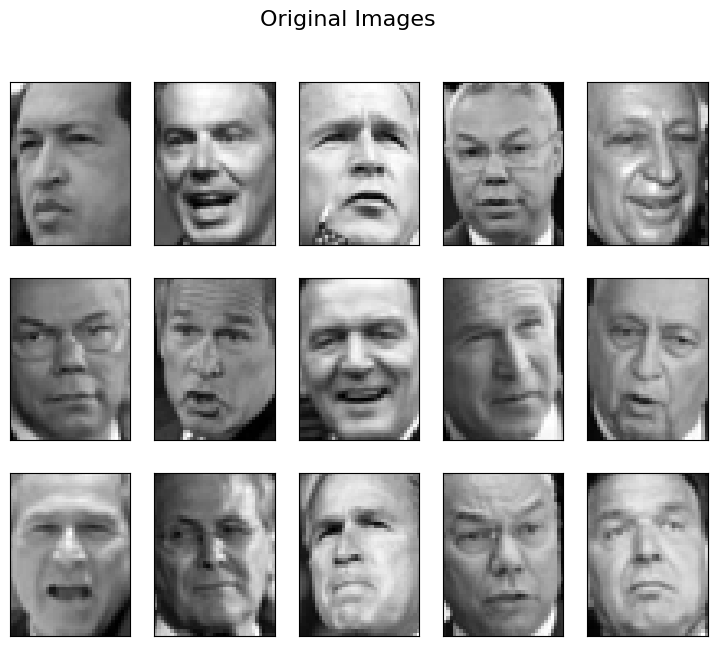

Visualizing PCA components...


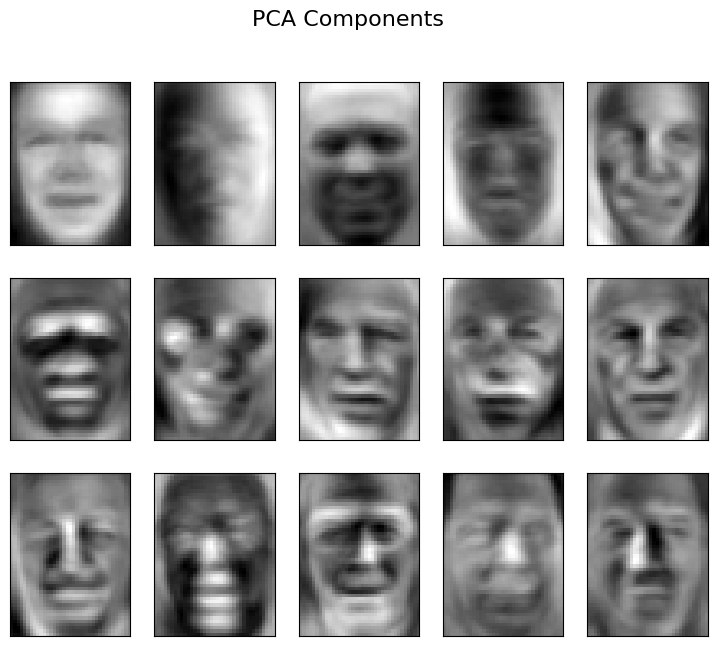

Visualizing personalized SSPCA components...


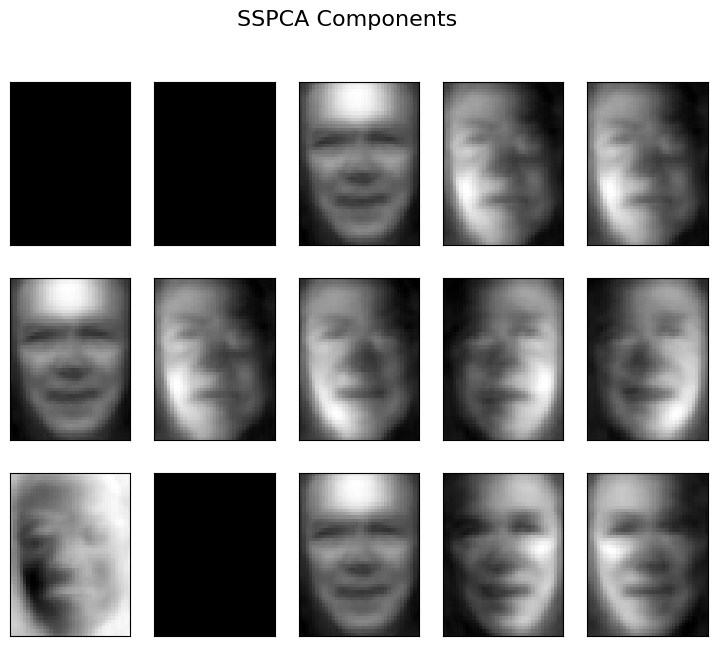

Visualizing Mini Batch SSPCA components...


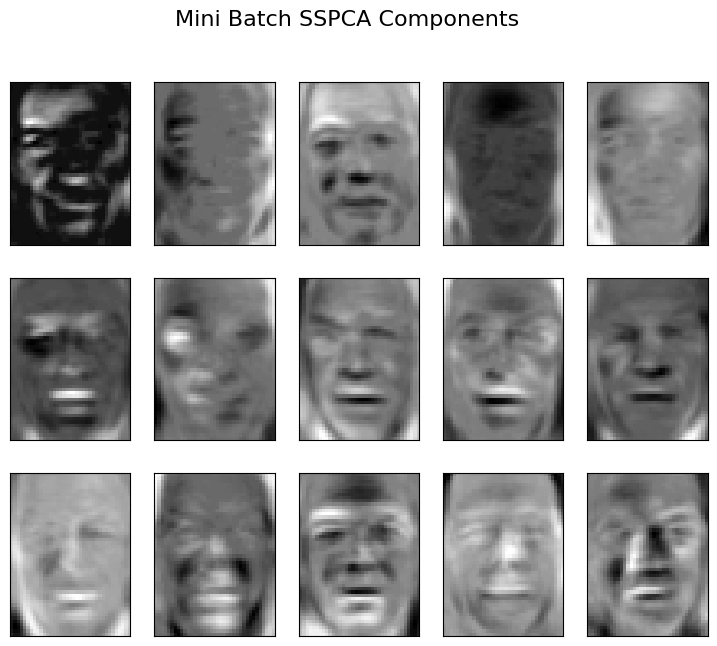

In [30]:
def plot_gallery(title, images, n_col=5, n_row=3, image_shape=(h, w)):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images[:n_col * n_row]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()

print("Visualizing Original Images...")
plot_gallery("Original Images", X)

print("Visualizing PCA components...")
plot_gallery("PCA Components", pca_components, image_shape=(h, w))

print("Visualizing personalized SSPCA components...")
plot_gallery("SSPCA Components", sspca_components, image_shape=(h, w))

print("Visualizing Mini Batch SSPCA components...")
plot_gallery("Mini Batch SSPCA Components", mb_sspca_components, image_shape=(h, w))


### Reconstruction Error Comparison

In [31]:
X_pca_reconstructed = pca.inverse_transform(X_pca)
X_sspca_reconstructed = X_scaled @ sspca_components.T @ sspca_components
X_mb_sspca_reconstructed = X_scaled @ mb_sspca_components.T @ mb_sspca_components

pca_reconstruction_error = np.mean((X_scaled - X_pca_reconstructed) ** 2)
sspca_reconstruction_error = np.mean((X_scaled - X_sspca_reconstructed) ** 2)
mb_sspca_reconstruction_error = np.mean((X_scaled - X_mb_sspca_reconstructed) ** 2)

print(f"PCA Reconstruction Error: {pca_reconstruction_error:.4f}")
print(f"Personalized SSPCA Reconstruction Error: {sspca_reconstruction_error:.4f}")
print(f"Mini Batch SSPCA Reconstruction Error: {mb_sspca_reconstruction_error:.4f}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 163 is different from 171)